In [859]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl
import random

# GERANDO DADOS RUIDOSOS

TransferFunction(array([816.33823141]), array([  1.        ,  16.        , 816.33823141]))

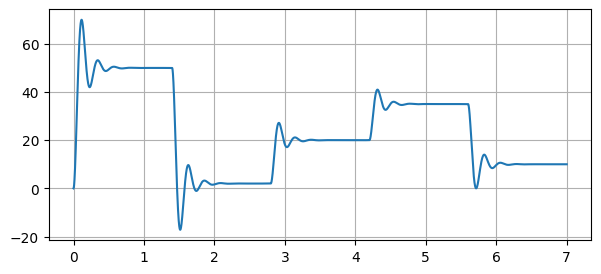

In [860]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array

def makeTransferFunction(Ts, UP):
    zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
    Wn = 4/(zeta*Ts)
    s = ctl.TransferFunction.s
    return Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

size = 10000
tData = np.linspace(0, 7, size)
uData = makeSteps([50, 2, 20, 35, 10], size)
G = makeTransferFunction(Ts=0.5, UP=0.40)
display(G)

time, response = ctl.forced_response(G, T=tData, U=uData)
plt.figure(figsize=(7, 3))
plt.plot(time, response)
plt.grid()

In [861]:
def noise(value, noiseLevel=0.05):
    if random.randint(0, 100) in [c for c in range(0, 100, 10)]:
        noiseLevel = .9*value

    noise = random.uniform(-noiseLevel, noiseLevel)
    return (value + noise) if (noise < value) else value

df = pd.DataFrame({'time': time, 'input': uData, 'output': response})
df['output'] = df.output.apply(noise)

df.to_csv('DataBase.csv', index=None)
df.head()

,time,input,output
0,0.0000,50.0,-0.004586
1,0.0007,50.0,0.009965
2,0.0014,50.0,0.039706
3,0.0021,50.0,0.082198
4,0.0028,50.0,0.109158


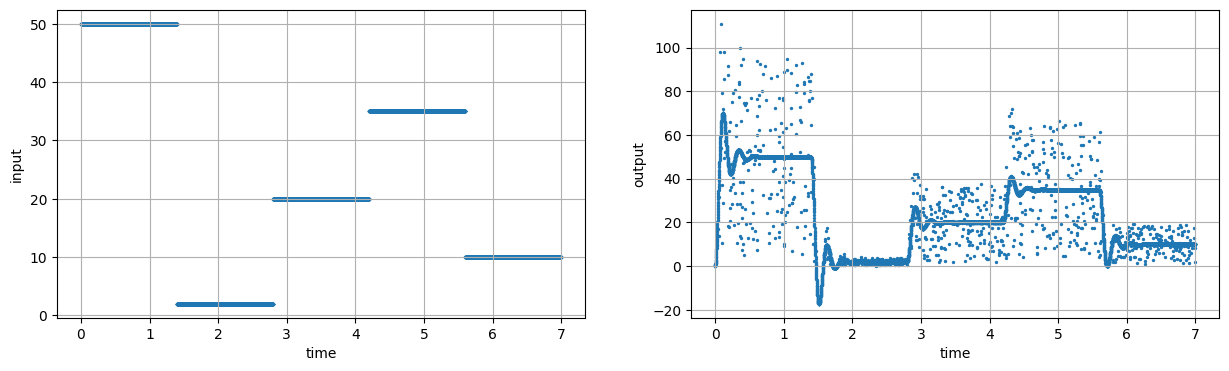

In [862]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.scatter(df.time, df.input, s=2)
plt.xlabel('time'), plt.ylabel('input')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.xlabel('time'), plt.ylabel('output')
plt.grid()

# PADRONIZANDO OS DADOS

In [863]:
def reduceDataFrame(df, size):
    total   = len(df)
    indexes = np.linspace(0, total - 1, size, dtype=int)
    return df.iloc[indexes].reset_index(drop=True)

print('size', len(df), 'reduced to', 5000)
df = reduceDataFrame(df, 5000)

size 10000 reduced to 5000


In [864]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData = np.arange(initTime, finalTime, T)
    
    lastValue  = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


T = 0.005
tData, uData = normalizeData(df, 'time', 'input',  T)
tData, yData = normalizeData(df, 'time', 'output', T)

df = normalizeTable(df, 'time', T)
print('size:', len(df))
df.head()

size: 1401


,time,input,output
0,0.000,50.0,-0.004586
1,0.005,50.0,0.396542
2,0.010,50.0,1.869350
3,0.015,50.0,3.657251
4,0.020,50.0,6.937523


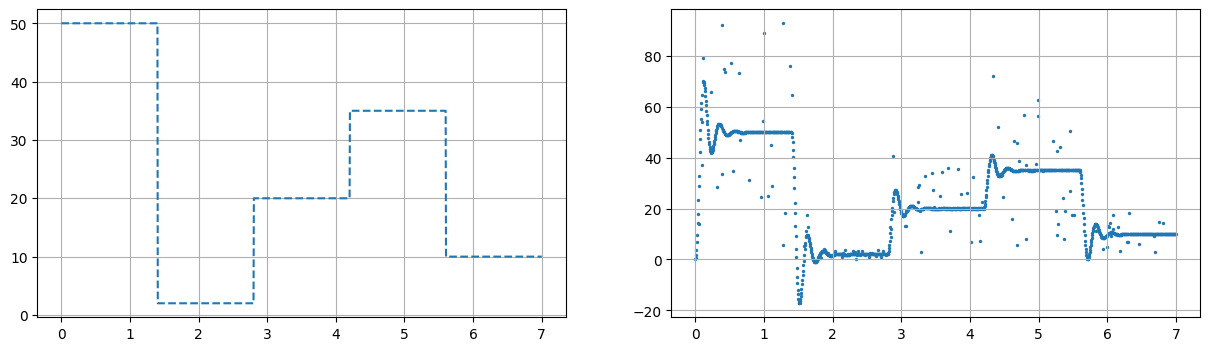

In [865]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(tData, uData, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(tData, yData, s=2)
plt.grid()

# FILTRANDO OS DADOS
**Filtro de Savitzky-Golay**: Este filtro ajusta um polinômio de baixa ordem a uma janela deslizante de pontos de dados, preservando a forma geral dos dados (como picos e vales) enquanto suaviza o ruído. Ideal para preservar as características da curva.



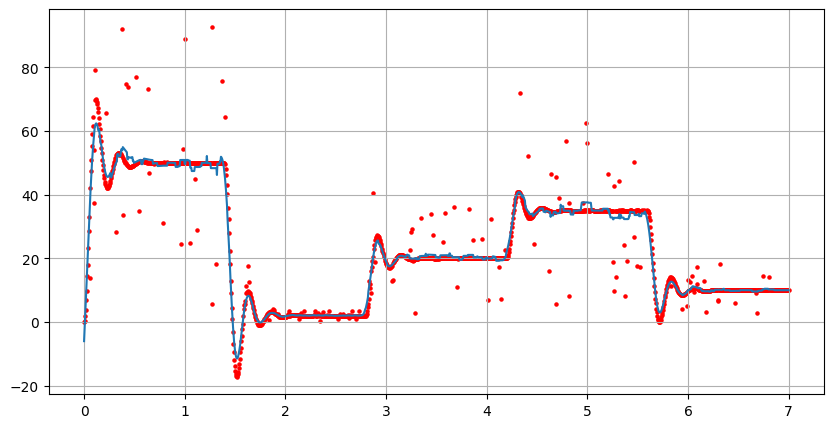

In [866]:
from scipy.signal import savgol_filter

windowLength = 20
polyOrder    = 1

yFiltered = savgol_filter(yData, window_length=windowLength, polyorder=polyOrder)
plt.figure(figsize=(10, 5))

plt.scatter(tData, yData, s=5, color='red')
plt.plot(tData, yFiltered)
plt.grid()

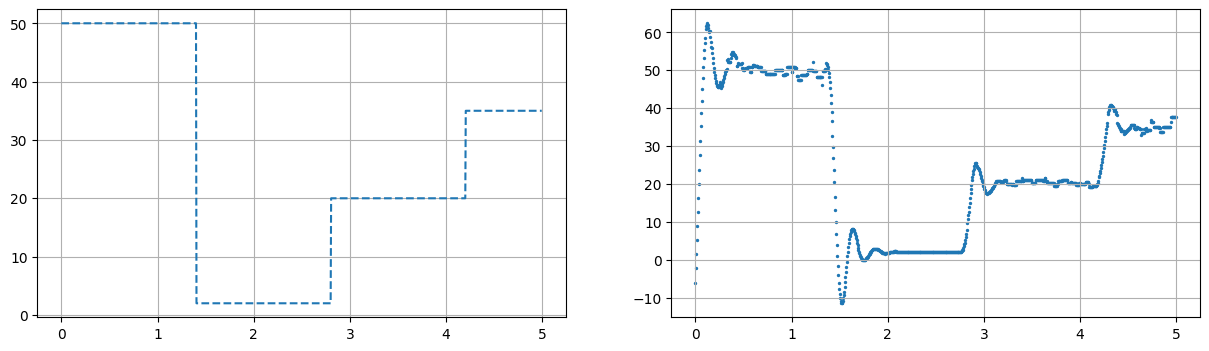

In [867]:
df['output'] = yFiltered
df = df.loc[df.time < 5]

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.grid()

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [868]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

In [869]:
def g(u, a, b, c):
    s = ctl.TransferFunction.s
    G = a/(s**2 + b*s + c)
    return ctl.forced_response(G, T=tData, U=uData)[1]

def getFunction(xDados, yDados):
    coeficientes = curve_fit(g, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [870]:
coefs = getFunction(uData, yData)  
coefs

[845.2849022256369, 21.447897478788775, 845.6561369140611]

In [871]:
s = ctl.TransferFunction.s
a, b, c = coefs

G = a/(s**2 + b*s + c)
G

TransferFunction(array([845.28490223]), array([  1.        ,  21.44789748, 845.65613691]))

### CONFERINDO COM A DATABASE

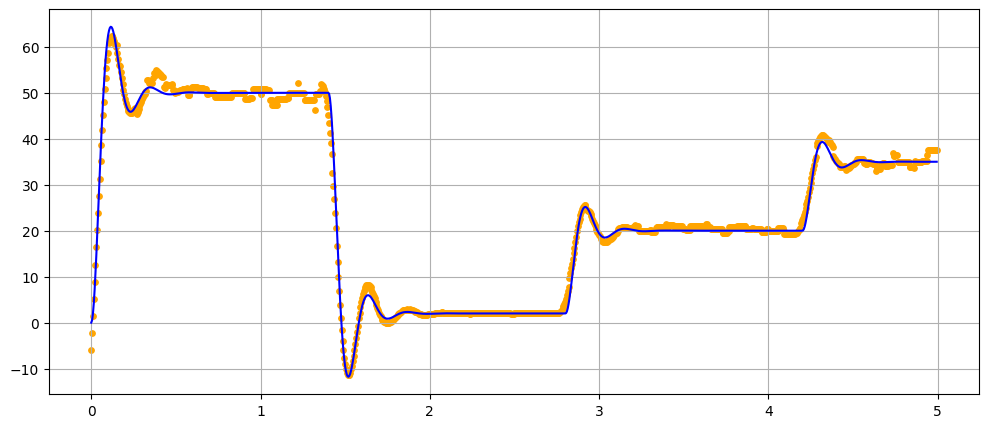

In [872]:
time, response = ctl.forced_response(G, T=tData, U=uData)

plt.figure(figsize=(12, 5))
plt.plot(time, response, color='blue')
plt.scatter(tData, yData, color='orange', s=15)
plt.grid()

In [873]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

print(sympyFunction(G))

845.284902225637/(1.0*s**2 + 21.4478974787888*s + 845.656136914061)
